In [1]:
import sys
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from ddpg_agent import Agent

%matplotlib inline

# Training scores

In [2]:
scores = pickle.load(open('./scores.p', 'rb'))

In [3]:
scores_mean = [scores[0]]
scores_05 = [scores[0]]
scores_95 = [scores[0]]
scores_std = [0]
scores_above30 = [int((scores[0] >= 30))]
for i in range(1, len(scores)):
    seg = scores[max(0, i-100):i]
    scores_mean.append(np.mean(seg))
    scores_05.append(np.percentile(seg, 5))
    scores_95.append(np.percentile(seg, 95))
    scores_std.append(np.std(seg))
    scores_above30.append(np.sum([1 for x in seg if x >=30]))
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)


In [4]:
x = np.arange(len(scores))

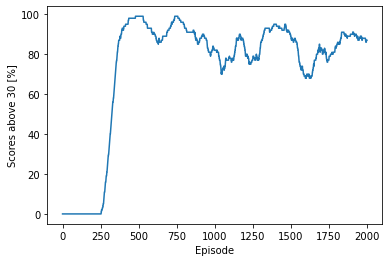

In [5]:
f = plt.figure()
plt.plot(x, scores_above30)
plt.xlabel('Episode')
plt.ylabel('Scores above 30 [%]')
plt.show()

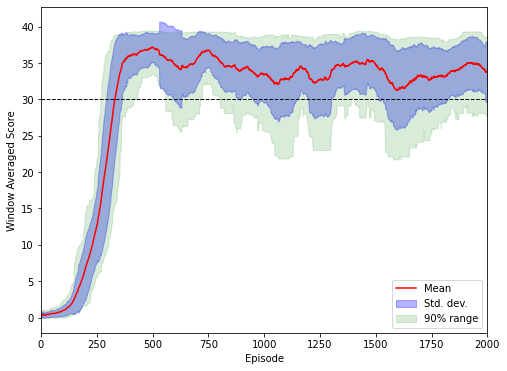

Avg. score 30 threshold achieved after 432 episodes.


In [6]:
def plot_mean_chart(x, scores_mean, scores_std, scores_05, scores_95, filename = None, xticks=None):
    f = plt.figure(figsize=(8, 6))
    plt.plot(x, scores_mean, '-', color = 'r')
    plt.fill_between(x, scores_mean - scores_std, scores_mean + scores_std, alpha = 0.30, color = 'b')
    plt.fill_between(x, scores_05, scores_95, alpha = 0.15, color = 'g')
    plt.xlabel('Episode')
    plt.ylabel('Window Averaged Score')
    plt.hlines(30, 0, len(scores), colors='black', linestyles='--', linewidth=1)
    plt.xlim(0, len(scores))
    plt.legend(['Mean', 'Std. dev.', '90% range'], loc='lower right')
    if xticks is not None:
        plt.xticks(xticks)

    if filename is not None:
        plt.savefig(filename)
    plt.show()

plot_mean_chart(x, scores_mean, scores_std, scores_05, scores_95, './img/averaged_scores_train.jpg')
print ('Avg. score 30 threshold achieved after {} episodes.'.format(101+np.argmax(scores_mean >=30)))


In [7]:
def print_val(episode):
    pos = (episode - 1 if episode >= 0 else episode)
    print ('Mean:     {:.2f}'.format(scores_mean[pos]))
    print ('Std dev.: {:.2f}'.format(scores_std[pos]))
    print ('Above 30: {}%'.format(scores_above30[pos]))
    

In [8]:
print_val(500)

Mean:     37.15
Std dev.: 2.04
Above 30: 99%


# Testing scores

In [9]:
test_scores = pickle.load(open('./test_scores.p', 'rb'))
keys = list(test_scores.keys())
keys.sort()

In [10]:
test_scores_mean = []
test_scores_05 = []
test_scores_95 = []
test_scores_std = []
test_scores_above30 = []

for k in keys:
    seg = test_scores[k]
    test_scores_mean.append(np.mean(seg))
    test_scores_05.append(np.percentile(seg, 5))
    test_scores_95.append(np.percentile(seg, 95))
    test_scores_std.append(np.std(seg))
    test_scores_above30.append(np.sum([1 for x in seg if x >=30]))
test_scores_mean = np.array(test_scores_mean)
test_scores_std = np.array(test_scores_std)


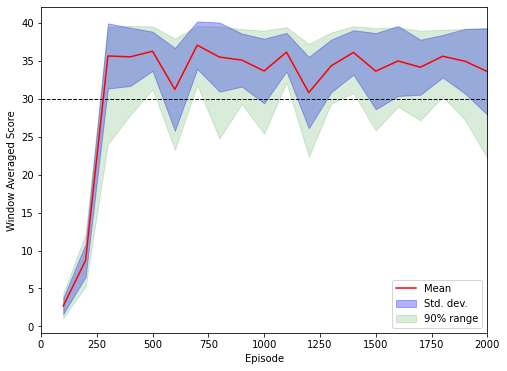

In [11]:
plot_mean_chart(keys, test_scores_mean, test_scores_std, 
                test_scores_05, test_scores_95, 
                './img/averaged_scores_test.jpg')


In [12]:
def print_test_scores(episode):
    pos = int (episode / 100) -1
    print ('Mean:     {:.2f}'.format(test_scores_mean[pos]))
    print ('Std dev.: {:.2f}'.format(test_scores_std[pos]))
    print ('Above 30: {}%'.format(test_scores_above30[pos]))

In [13]:
print_test_scores(500)

Mean:     36.24
Std dev.: 2.58
Above 30: 98%


# Let's see how the trained agent works

In [14]:
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64_OneAgent/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [15]:
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]


In [16]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

agent.actor_local.load_state_dict(torch.load('./models/checkpoint_actor_500.pth'))
agent.critic_local.load_state_dict(torch.load('./models/checkpoint_critic_500.pth'))

In [17]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations    
score = 0
step = 0
while True:
    action = agent.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations[0]        
    reward = env_info.rewards[0]                       
    done = env_info.local_done[0] 
    score += reward                         
    state = next_state                               
    sys.stdout.write('Step: {:,}, Reward: {:.3f}, Score: {:.3f}         \r'.format(step, reward, score))
    step += 1
    if done:                             
        break
print('\nTotal score: {:.3f}'.format(score))

Step: 1,000, Reward: 0.040, Score: 37.630         
Total score: 37.630


In [19]:
env.close()